In [1]:
import pandas as pd
from yahoo import historical_stocks_data
import en_core_web_sm
nlp = en_core_web_sm.load()

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

main_tickers = ["AAPL", "MSFT", "NVDA", "GOOG", "AMZN", "META", "BRK-B", "TSM", "LLY", "TSLA", "AVGO"]

2024-09-14 12:53:38.147688: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-14 12:53:38.148302: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-14 12:53:38.150657: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-14 12:53:38.157039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 12:53:38.167650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

https://www.kaggle.com/datasets/suchandramajumder/news-headlines-against-stocks/data

In [2]:
data = pd.read_csv("data/headlines_with_tickers.csv")
data = data[data["stock"].isin(main_tickers)]

In [3]:
data["stock"].value_counts()

stock
AVGO    2488
TSM     1607
LLY     1121
AAPL      32
GOOG       5
Name: count, dtype: int64

The data is downloaded from Kaggle: https://www.kaggle.com/datasets/johoetter/labeled-stock-news-headlines.

In [4]:
ticker_df = historical_stocks_data(main_tickers)
ticker_df = ticker_df.pct_change()
ticker_df = ticker_df.apply(lambda col: col.shift(1) + col + col.shift(-1))
ticker_df

,AAPL,MSFT,NVDA,GOOG,AMZN,META,BRK-B,TSM,LLY,TSLA,AVGO
Date,,,,,,,,,,,
2014-09-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-17,0.001630,0.009552,0.030512,0.027959,0.003563,0.032171,0.023304,0.033243,0.021346,0.038891,0.035840
2014-09-18,0.001052,0.016302,-0.002852,0.027563,0.011061,0.023876,0.013499,0.002265,0.011087,-0.005268,0.017194
2014-09-19,-0.005096,0.011754,-0.013333,0.004640,0.001948,0.005029,-0.002383,-0.012369,0.002652,-0.043546,-0.005953
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-09,-0.010229,0.014527,0.009853,-0.053383,0.010518,-0.023063,-0.012918,-0.006173,-0.012569,-0.012394,-0.023159
2024-09-10,0.008371,0.052251,0.132206,0.001678,0.074737,0.022982,-0.013770,0.083876,0.020222,0.080732,0.148238
2024-09-11,0.008458,0.051604,0.115970,0.039689,0.064781,0.040850,-0.019105,0.056637,0.029407,0.061806,0.160097


The data is downloaded from Kaggle: https://www.kaggle.com/datasets/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests?select=raw_partner_headlines.csv

In [5]:
news_data = pd.read_csv("data/raw_partner_headlines.csv", index_col=0)
news_data = news_data[news_data["stock"].isin(main_tickers)]
news_data.index = pd.to_datetime(news_data["date"])
news_data

,headline,url,publisher,date,stock
date,,,,,
2020-06-02,American Pie,https://talkmarkets.com/content/american-pie?p...,TalkMarkets,2020-06-02 00:00:00,AAPL
2020-06-02,Tech Giants Dare Antitrust Deal Watchdogs,https://talkmarkets.com/content/tech-giants-da...,TalkMarkets,2020-06-02 00:00:00,AAPL
2020-06-02,MoneyGram Shares Jump 50% As Western Union Rep...,https://talkmarkets.com/content/moneygram-shar...,TalkMarkets,2020-06-02 00:00:00,AAPL
2020-06-01,All Eyes on Market Volatility,https://talkmarkets.com/content/all-eyes-on-ma...,TalkMarkets,2020-06-01 00:00:00,AAPL
2020-06-01,Warren Buffett's Berkshire Hathaway Turns Up S...,http://www.gurufocus.com/news/1152965/warren-b...,GuruFocus,2020-06-01 00:00:00,AAPL
...,...,...,...,...,...
2010-06-28,Trade Pact to Boost Taiwan ETF,https://www.benzinga.com/content/thestreet-com...,webmaster,2010-06-28 00:00:00,TSM
2010-06-24,China's IC Industry in Rapid Expansion,https://www.benzinga.com/content/thestreet-com...,webmaster,2010-06-24 00:00:00,TSM
2010-06-16,ETFs for a Chip Rally,https://www.benzinga.com/content/thestreet-com...,webmaster,2010-06-16 00:00:00,TSM


In [6]:
merged_data = pd.merge(ticker_df, news_data, how="right", left_index=True, right_index=True).dropna()
merged_data

,AAPL,MSFT,NVDA,GOOG,AMZN,META,BRK-B,TSM,LLY,TSLA,AVGO,headline,url,publisher,date,stock
Date,,,,,,,,,,,,,,,,
2020-06-02,0.022432,0.011518,-0.011962,0.005224,0.014716,0.022791,0.028292,0.053301,-0.002664,0.058740,0.061916,American Pie,https://talkmarkets.com/content/american-pie?p...,TalkMarkets,2020-06-02 00:00:00,AAPL
2020-06-02,0.022432,0.011518,-0.011962,0.005224,0.014716,0.022791,0.028292,0.053301,-0.002664,0.058740,0.061916,Tech Giants Dare Antitrust Deal Watchdogs,https://talkmarkets.com/content/tech-giants-da...,TalkMarkets,2020-06-02 00:00:00,AAPL
2020-06-02,0.022432,0.011518,-0.011962,0.005224,0.014716,0.022791,0.028292,0.053301,-0.002664,0.058740,0.061916,MoneyGram Shares Jump 50% As Western Union Rep...,https://talkmarkets.com/content/moneygram-shar...,TalkMarkets,2020-06-02 00:00:00,AAPL
2020-06-01,0.015953,0.019283,0.040131,0.015802,0.029481,0.032151,0.004640,0.034107,0.021247,0.093377,0.052148,All Eyes on Market Volatility,https://talkmarkets.com/content/all-eyes-on-ma...,TalkMarkets,2020-06-01 00:00:00,AAPL
2020-06-01,0.015953,0.019283,0.040131,0.015802,0.029481,0.032151,0.004640,0.034107,0.021247,0.093377,0.052148,Warren Buffett's Berkshire Hathaway Turns Up S...,http://www.gurufocus.com/news/1152965/warren-b...,GuruFocus,2020-06-01 00:00:00,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-11-07,0.004061,0.021454,-0.005173,0.002970,0.028768,0.002327,0.014849,0.010642,0.020452,0.047352,-0.008716,Taiwan Semiconductor In Buy Range From Breakout,http://news.investors.com/110714-725628-taiwan...,Investor's Business Daily,2014-11-07 00:00:00,TSM
2014-11-05,-0.002059,0.026388,0.017556,-0.023887,-0.029886,0.018917,0.017523,-0.004512,0.006340,-0.004024,0.015075,16 Incredible Stocks Converting Growth In Pure...,http://www.gurufocus.com/news/289869/16-incred...,GuruFocus,2014-11-05 00:00:00,TSM
2014-10-10,-0.009822,-0.068205,-0.081913,-0.070235,-0.051199,-0.059192,-0.025552,-0.044797,-0.030303,-0.138965,-0.179564,Q3 Earnings Season Ramps Up - Earnings Preview,http://www.zacks.com/commentary/34810/q3-earni...,Zacks,2014-10-10 00:00:00,TSM


In [7]:
def select_ticker(row):
    return row[row["stock"]]

merged_data["event_return"] = merged_data.apply(select_ticker, axis=1)
merged_data.drop(columns=main_tickers, inplace=True)

In [8]:
merged_data

,headline,url,publisher,date,stock,event_return
Date,,,,,,
2020-06-02,American Pie,https://talkmarkets.com/content/american-pie?p...,TalkMarkets,2020-06-02 00:00:00,AAPL,0.022432
2020-06-02,Tech Giants Dare Antitrust Deal Watchdogs,https://talkmarkets.com/content/tech-giants-da...,TalkMarkets,2020-06-02 00:00:00,AAPL,0.022432
2020-06-02,MoneyGram Shares Jump 50% As Western Union Rep...,https://talkmarkets.com/content/moneygram-shar...,TalkMarkets,2020-06-02 00:00:00,AAPL,0.022432
2020-06-01,All Eyes on Market Volatility,https://talkmarkets.com/content/all-eyes-on-ma...,TalkMarkets,2020-06-01 00:00:00,AAPL,0.015953
2020-06-01,Warren Buffett's Berkshire Hathaway Turns Up S...,http://www.gurufocus.com/news/1152965/warren-b...,GuruFocus,2020-06-01 00:00:00,AAPL,0.015953
...,...,...,...,...,...,...
2014-11-07,Taiwan Semiconductor In Buy Range From Breakout,http://news.investors.com/110714-725628-taiwan...,Investor's Business Daily,2014-11-07 00:00:00,TSM,0.010642
2014-11-05,16 Incredible Stocks Converting Growth In Pure...,http://www.gurufocus.com/news/289869/16-incred...,GuruFocus,2014-11-05 00:00:00,TSM,-0.004512
2014-10-10,Q3 Earnings Season Ramps Up - Earnings Preview,http://www.zacks.com/commentary/34810/q3-earni...,Zacks,2014-10-10 00:00:00,TSM,-0.044797


In [9]:
merged_data["stock"]

Date
2020-06-02    AAPL
2020-06-02    AAPL
2020-06-02    AAPL
2020-06-01    AAPL
2020-06-01    AAPL
              ... 
2014-11-07     TSM
2014-11-05     TSM
2014-10-10     TSM
2014-09-17     TSM
2014-09-17     TSM
Name: stock, Length: 4614, dtype: object

# Evaluate model for sentiment analysis

In [10]:
text1 = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the company should be reversed."

In [11]:
from textblob import TextBlob
TextBlob(text1).sentiment

Sentiment(polarity=0.5, subjectivity=0.5)

In [12]:
merged_data["sentiment_textblob"] = [TextBlob(text).sentiment.polarity for text in merged_data["headline"]]
merged_data

,headline,url,publisher,date,stock,event_return,sentiment_textblob
Date,,,,,,,
2020-06-02,American Pie,https://talkmarkets.com/content/american-pie?p...,TalkMarkets,2020-06-02 00:00:00,AAPL,0.022432,0.000000
2020-06-02,Tech Giants Dare Antitrust Deal Watchdogs,https://talkmarkets.com/content/tech-giants-da...,TalkMarkets,2020-06-02 00:00:00,AAPL,0.022432,0.000000
2020-06-02,MoneyGram Shares Jump 50% As Western Union Rep...,https://talkmarkets.com/content/moneygram-shar...,TalkMarkets,2020-06-02 00:00:00,AAPL,0.022432,0.000000
2020-06-01,All Eyes on Market Volatility,https://talkmarkets.com/content/all-eyes-on-ma...,TalkMarkets,2020-06-01 00:00:00,AAPL,0.015953,0.000000
2020-06-01,Warren Buffett's Berkshire Hathaway Turns Up S...,http://www.gurufocus.com/news/1152965/warren-b...,GuruFocus,2020-06-01 00:00:00,AAPL,0.015953,0.000000
...,...,...,...,...,...,...,...
2014-11-07,Taiwan Semiconductor In Buy Range From Breakout,http://news.investors.com/110714-725628-taiwan...,Investor's Business Daily,2014-11-07 00:00:00,TSM,0.010642,0.000000
2014-11-05,16 Incredible Stocks Converting Growth In Pure...,http://www.gurufocus.com/news/289869/16-incred...,GuruFocus,2014-11-05 00:00:00,TSM,-0.004512,0.557143
2014-10-10,Q3 Earnings Season Ramps Up - Earnings Preview,http://www.zacks.com/commentary/34810/q3-earni...,Zacks,2014-10-10 00:00:00,TSM,-0.044797,0.000000


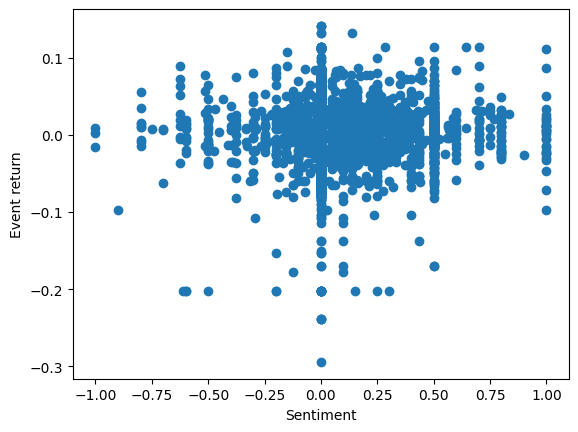

In [13]:
import matplotlib.pyplot as plt

plt.scatter(merged_data["sentiment_textblob"], merged_data["event_return"])
plt.xlabel("Sentiment")
plt.ylabel("Event return")
plt.show()

In [14]:
merged_data["sentiment_textblob"].corr(merged_data["event_return"])

0.02024863488704795

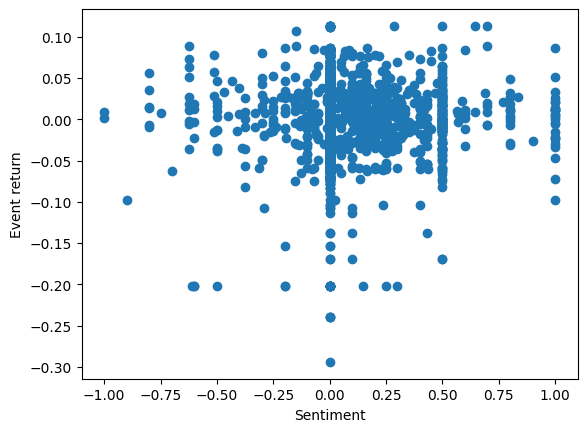

In [15]:
merged_data_Broadcom = merged_data[merged_data["stock"] == "AVGO"]
plt.scatter(merged_data_Broadcom["sentiment_textblob"], merged_data_Broadcom["event_return"])
plt.xlabel("Sentiment")
plt.ylabel("Event return")
plt.show()

In [16]:
TextBlob(text1).sentiment_assessments

Sentiment(polarity=0.5, subjectivity=0.5, assessments=[(['touching'], 0.5, 0.5, None)])

# Supervised learning using classification algorithms and LSTM

In [17]:
sentiment_data = pd.read_csv("data/stock_news.csv", index_col=0)
sentiment_data

,headline,label
0,"Markets Close Mostly Lower Again; ROST, PANW R...",Negative
1,"Gap plummets on earnings miss, cuts full-year ...",Negative
2,Billionaire Ken Fisher is Selling These 10 Stocks,Negative
3,"Corning net income drops 13%, shares fall",Negative
4,Internet Explorer shutdown to cause Japan prob...,Negative
...,...,...
25995,"Boston Scientific (BSX) Q1 Earnings Top, 2022 ...",Positive
25996,Producer sentiment improves with strengthened ...,Positive
25997,Equinix Declares Quarterly Dividend on Its Com...,Positive
25998,FEATURE-'Love Island' dumps fast fashion for s...,Positive


In [18]:
def map_label(label):
    temp = {
        "Negative": 0,
        "Neutral": 0.5,
        "Positive": 1
    }
    return temp[label]
sentiment_data["label"] = sentiment_data["label"].apply(map_label)

In [19]:
sentiment_data

,headline,label
0,"Markets Close Mostly Lower Again; ROST, PANW R...",0.0
1,"Gap plummets on earnings miss, cuts full-year ...",0.0
2,Billionaire Ken Fisher is Selling These 10 Stocks,0.0
3,"Corning net income drops 13%, shares fall",0.0
4,Internet Explorer shutdown to cause Japan prob...,0.0
...,...,...
25995,"Boston Scientific (BSX) Q1 Earnings Top, 2022 ...",1.0
25996,Producer sentiment improves with strengthened ...,1.0
25997,Equinix Declares Quarterly Dividend on Its Com...,1.0
25998,FEATURE-'Love Island' dumps fast fashion for s...,1.0


In [20]:
import numpy as np

# We take the mean of the embedding vectors of all words in a sentence
# (print(np.array([token.vector for token in nlp(headline)]).mean(axis=0).shape) for headline in sentiment_data["headline"]

all_vectors = np.array([np.array([token.vector for token in nlp(headline)]).mean(axis=0) for headline in sentiment_data['headline']])
all_vectors.shape

(26000, 96)

In [21]:
all_vectors = pd.DataFrame(all_vectors)

In [22]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

X = all_vectors
y = sentiment_data["label"]
y = encoder.fit_transform(y)

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
valid_size = 0.3
seed = 42

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=valid_size, random_state=42, shuffle=True)

In [23]:
num_folds = 10
scoring = "accuracy"

models = []

models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
models.append(('RF', RandomForestClassifier()))

In [24]:
results = []
names = []
valid_results = []
train_results = []
for name, model in models:
    k_fold = KFold(num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=scoring)
    results.append(cv_results)
    names.append(name)

    result = model.fit(X_train, y_train)
    train_result = mean_squared_error(result.predict(X_train), y_train)
    train_results.append(train_result)

    valid_result = mean_squared_error(result.predict(X_valid), y_valid)
    valid_results.append(valid_result)
    
    print(f"{name}: ")
    print(confusion_matrix(result.predict(X_valid), y_valid))
    print(classification_report(result.predict(X_valid), y_valid))

/home/tan/miniconda3/envs/finance/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/tan/miniconda3/envs/finance/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

LR: 
[[ 431  147  260]
 [ 224 1289  619]
 [ 791 1177 2862]]
              precision    recall  f1-score   support

           0       0.30      0.51      0.38       838
           1       0.49      0.60      0.54      2132
           2       0.77      0.59      0.67      4830

    accuracy                           0.59      7800
   macro avg       0.52      0.57      0.53      7800
weighted avg       0.64      0.59      0.60      7800

KNN: 
[[ 718  218  413]
 [ 234 1531  715]
 [ 494  864 2613]]
              precision    recall  f1-score   support

           0       0.50      0.53      0.51      1349
           1       0.59      0.62      0.60      2480
           2       0.70      0.66      0.68      3971

    accuracy                           0.62      7800
   macro avg       0.59      0.60      0.60      7800
weighted avg       0.63      0.62      0.63      7800

CART: 
[[ 525  359  628]
 [ 352 1268 1040]
 [ 569  986 2073]]
              precision    recall  f1-score   support



/home/tan/miniconda3/envs/finance/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tan/miniconda3/envs/finance/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tan/miniconda3/envs/finance/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tan/miniconda3/envs/finance/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

NN: 
[[ 683  210  399]
 [ 246 1562  833]
 [ 517  841 2509]]
              precision    recall  f1-score   support

           0       0.47      0.53      0.50      1292
           1       0.60      0.59      0.59      2641
           2       0.67      0.65      0.66      3867

    accuracy                           0.61      7800
   macro avg       0.58      0.59      0.58      7800
weighted avg       0.61      0.61      0.61      7800

RF: 
[[ 427   53  129]
 [ 189 1391  492]
 [ 830 1169 3120]]
              precision    recall  f1-score   support

           0       0.30      0.70      0.42       609
           1       0.53      0.67      0.59      2072
           2       0.83      0.61      0.70      5119

    accuracy                           0.63      7800
   macro avg       0.55      0.66      0.57      7800
weighted avg       0.71      0.63      0.65      7800



In [25]:
y_train

array([0, 2, 0, ..., 0, 2, 2])

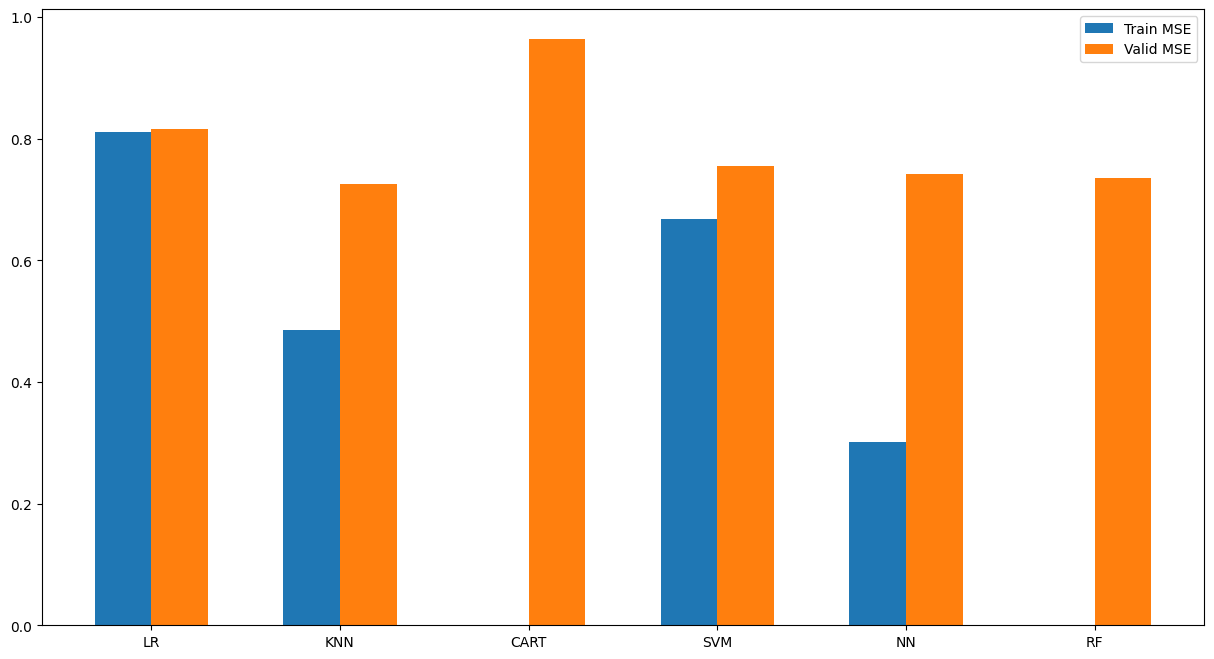

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
index = np.arange(len(names))
width = 0.3
plt.bar(index - width / 2, train_results, width=width, label="Train MSE")
plt.bar(index + width / 2, valid_results, width=width, label="Valid MSE")

plt.legend()
plt.xticks(ticks=range(len(names)), labels=names)
plt.show()

# LSTM

In [27]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words = vocabulary_size)
tokenizer.fit_on_texts(sentiment_data["headline"])
sequences = tokenizer.texts_to_sequences(sentiment_data["headline"])
X_LSTM = pad_sequences(sequences, maxlen=max([len(x) for x in sequences]))

In [28]:
X_train_LSTM, X_valid_LSTM, y_train_LSTM, y_valid_LSTM = train_test_split(X_LSTM, y, test_size=valid_size, shuffle=True, random_state=seed)

In [29]:
from scikeras.wrappers import KerasClassifier
def create_model():
    model = Sequential(
        [
            Embedding(vocabulary_size, 300),
            LSTM(100, dropout=0.2, recurrent_dropout=0.2),
            Dense(1, activation="sigmoid")
        ]
    )
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model
LSTM_model = create_model()
LSTM_model.fit(X_train_LSTM, y_train_LSTM, epochs=3)

Epoch 1/3
569/569 ━━━━━━━━━━━━━━━━━━━━ 37s 62ms/step - accuracy: 0.3389 - loss: -6.7921
Epoch 2/3
569/569 ━━━━━━━━━━━━━━━━━━━━ 35s 61ms/step - accuracy: 0.3339 - loss: -23.6515
Epoch 3/3
569/569 ━━━━━━━━━━━━━━━━━━━━ 35s 62ms/step - accuracy: 0.3404 - loss: -47.8674


In [30]:
from sklearn.metrics import mean_squared_error
train_result_LSTM = mean_squared_error(LSTM_model.predict(X_train_LSTM), y_train_LSTM)
valid_result_LSTM = mean_squared_error(LSTM_model.predict(X_valid_LSTM), y_valid_LSTM)
train_result_LSTM, valid_result_LSTM

569/569 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


(0.636447973721891, 0.6484356288932596)

In [31]:
train_results.append(train_result_LSTM)
valid_results.append(valid_result_LSTM)
names.append("LSTM")

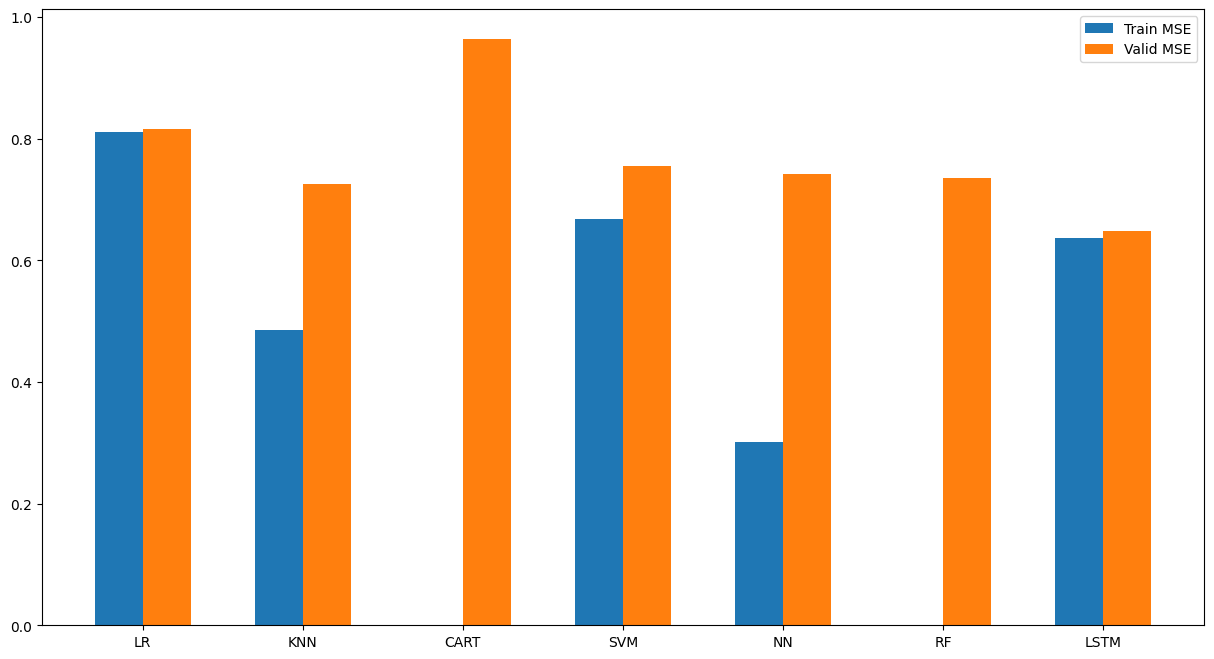

In [32]:
plt.figure(figsize=(15, 8))
index = np.arange(len(names))
width = 0.3
plt.bar(index - width / 2, train_results, width=width, label="Train MSE")
plt.bar(index + width / 2, valid_results, width=width, label="Valid MSE")

plt.legend()
plt.xticks(ticks=range(len(names)), labels=names)
plt.show()

In [33]:
sequences_LSTM = tokenizer.texts_to_sequences(merged_data["headline"])
X_LSTM = pad_sequences(sequences_LSTM, maxlen=max([len(x) for x in sequences]))
y_LSTM = LSTM_model.predict(X_LSTM)
merged_data["sentiment_lstm"] = y_LSTM

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [34]:
merged_data["sentiment_lstm"].corr(merged_data["event_return"])

0.033160066830583236

# Unsupervised

In [35]:
sia = SentimentIntensityAnalyzer()
stock_lex = pd.read_csv("data/LexiconData.csv")
stock_lex["sentiment"] = (stock_lex["Aff_Score"] + stock_lex["Neg_Score"]) / 2
stock_lex = dict(zip(stock_lex["Item"], stock_lex["sentiment"]))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(" ")) == 1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

final_lex = {}
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

In [36]:
text = "AAPL is trading higher after reporting its October sales rose 12.6% M/M. It has seen a 20%+ jump in orders"
sia.polarity_scores(text)

{'neg': 0.104, 'neu': 0.514, 'pos': 0.383, 'compound': 0.4535}

In [37]:
vader_sentiment = np.array([sia.polarity_scores(headline)["compound"] for headline in merged_data["headline"]])
vader_sentiment.shape

(4614,)

In [38]:
merged_data["sentiment_lexicon"] = vader_sentiment

In [39]:
merged_data["sentiment_lexicon"].corr(merged_data["event_return"])

0.04435619190759133

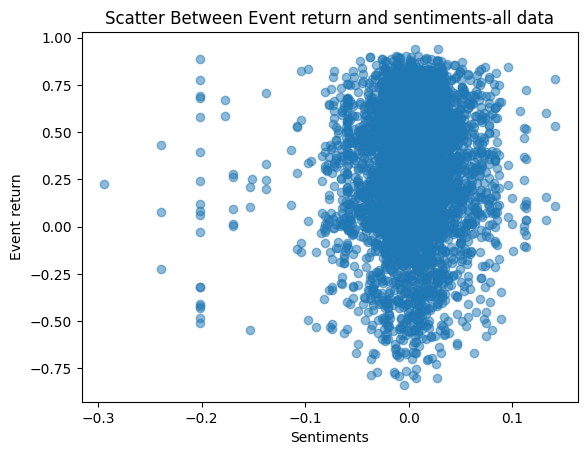

In [40]:
plt.scatter(merged_data["event_return"], merged_data["sentiment_lexicon"], alpha=0.5)
plt.xlabel("Sentiments")
plt.ylabel("Event return")
plt.title("Scatter Between Event return and sentiments-all data")
plt.show()

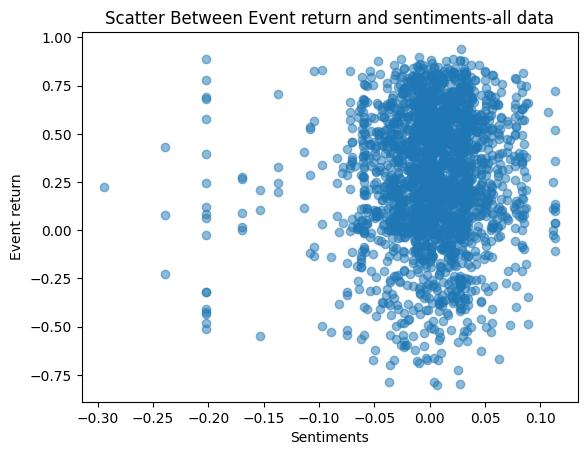

In [41]:
merged_data_Broadcom = merged_data[merged_data["stock"] == "AVGO"]
plt.scatter(merged_data_Broadcom["event_return"], merged_data_Broadcom["sentiment_lexicon"], alpha=0.5)
plt.xlabel("Sentiments")
plt.ylabel("Event return")
plt.title("Scatter Between Event return and sentiments-all data")
plt.show()

# EDA

<Axes: >

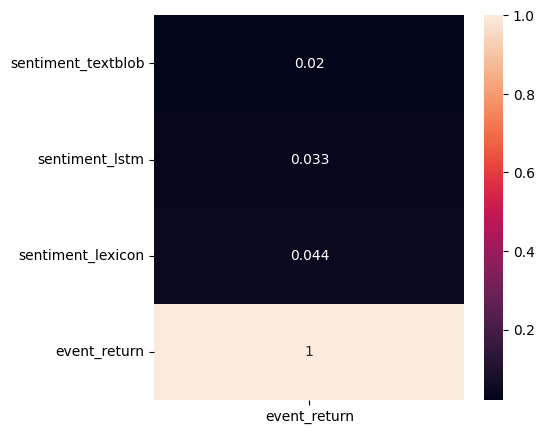

In [42]:
import seaborn as sns
correlation = merged_data[["sentiment_textblob", "sentiment_lstm", "sentiment_lexicon", "event_return"]].dropna(axis=0).corr()
plt.figure(figsize=(5, 5))
sns.heatmap(correlation[["event_return"]], vmax=1, annot=True)

In [43]:
correlation_data = []
for ticker in merged_data["stock"].unique():
    merged_data_stock = merged_data[merged_data["stock"] == ticker]
    corr_textblob = merged_data_stock["event_return"].corr(merged_data_stock["sentiment_textblob"])
    corr_lstm = merged_data_stock["event_return"].corr(merged_data_stock["sentiment_lstm"])
    corr_lexicon = merged_data_stock["event_return"].corr(merged_data_stock["sentiment_lexicon"])
    correlation_data.append([ticker, corr_textblob, corr_lstm, corr_lexicon])
correlation_df = pd.DataFrame(correlation_data, columns=["ticker", "corr_textblob", "corr_lstm", "corr_lexicon"])
correlation_df.set_index("ticker", inplace=True)
correlation_df.fillna(0, inplace=True)
correlation_df

/home/tan/miniconda3/envs/finance/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tan/miniconda3/envs/finance/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,corr_textblob,corr_lstm,corr_lexicon
ticker,,,
AAPL,-0.258442,0.185776,0.069831
AVGO,0.015772,0.055043,0.068044
GOOG,0.000000,-0.641805,-0.396404
LLY,0.046062,-0.041385,0.016965
TSM,0.018844,0.062751,0.014419


<Axes: xlabel='ticker'>

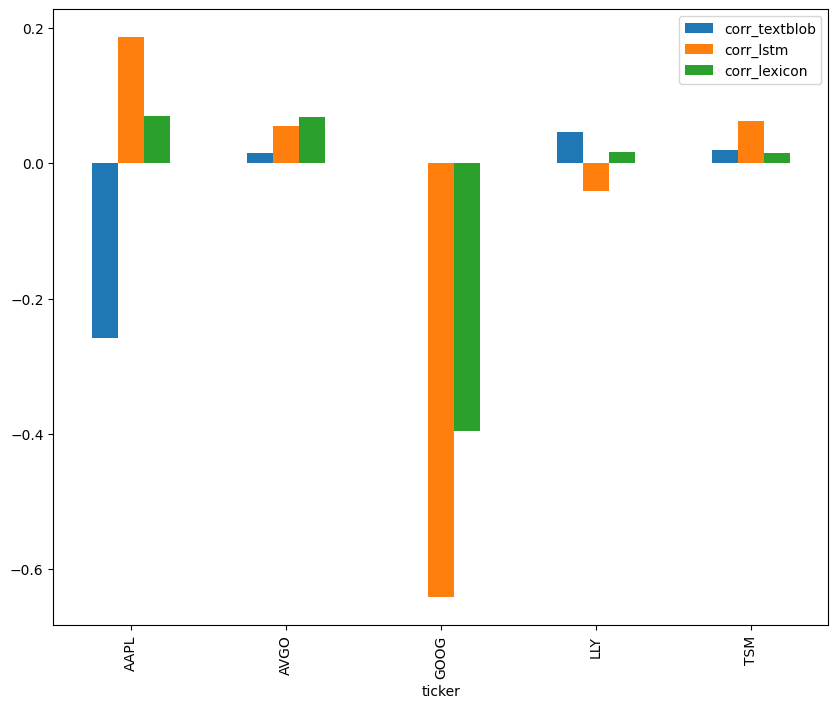

In [44]:
correlation_df.plot.bar(figsize=(10, 8))

# Trade strategy

In [2]:
import backtrader as bt
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers

class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    plotinfo = dict(
        plotymargin=0.5,
        plothlines=[0],
        plotyticks=[1.0, 0, -1.0])
    
    def next(self):
        self.sentiment = 0.0
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment        
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        self.lines.sentiment[0] = self.sentiment

In [1]:
class SentimentStrat(bt.Strategy):
    params = (
        ('period', 15),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f"{dt.isoformat()}, {txt}")
    
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.mas = bt.indicators.MovingAverageSimple(
            self.datas[0], period=self.params.period
        )
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        self.plotinfo.plot = False

    def notify_order(self, order:bt.Order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker, do nothing
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    f"BUY EXECUTED, Price : {order.executed.price}, Cost: {order.executed.value}, Commission {order.executed.comm}"
                )
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else: # Buy
                self.log(
                    f"BUY EXECUTED, Price : {order.executed.price}, Cost: {order.executed.value}, Commission {order.executed.comm}"
                )
            self.bar_executed = len(self)
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Order Canceled/Margin/Rejected")
        
        self.order = None
    
    def notify_trade(self, trade:bt.Trade):
        if not trade.isclosed:
            return
        
        self.log(
            f"Operation Profit, Gross: {trade.pnl}, Net: {trade.pnlcomm}"
        )

    def next(self):
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        
        # Check if there is an order pending. If yes, we cannot send a 2nd one
        if self.order:
            return
        # If not in the market and the previous sentiment is not None
        if not self.position and prev_sentiment:
            # buy if current close more than mas and sentiment increased by >= 0.5
            if self.dataclose[0] > self.mas[0] and self.sentiment - prev_sentiment >= 0.5:
                self.log(f"Previous Sentiment {prev_sentiment} New Sentiment {self.sentiment} BUY CREATE {self.dataclose[0]}")
                self.order = self.buy()
        # Already in the market and the previous sentiment is not None
        elif prev_sentiment:
            # sell if current close less than mas and sentiment decreased by >= 0.5
            if self.dataclose[0] > self.mas[0] and prev_sentiment - self.sentiment >= 0.5:
                self.log(f"Previous Sentiment {prev_sentiment} New Sentiment {self.sentiment} SELL CREATE {self.dataclose[0]}")
                self.order = self.sell()

    def stop(self):
        self.log(f"MA period {self.params.period} Ending Value {self.broker.getvalue()}", doprint=True)

NameError: name 'bt' is not defined

In [47]:
def run_strategy(ticker, start, end):
    print(ticker)
    import yfinance as yf
    ticker = yf.Ticker(ticker)
    df_ticker = ticker.history(start = start, end = end)
    
    cerebro = bt.Cerebro()
    # Add the data
    cerebro.addstrategy(SentimentStrat)        
    data = bt.feeds.PandasData(dataname=df_ticker)
    cerebro.adddata(data)    
    start = 100000.0
    cerebro.broker.setcash(start)   
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)
    print('Starting Portfolio Value: %.2f' % start)    
    plt.rcParams['figure.figsize']=[10,6]
    plt.rcParams["font.size"]="12"
    cerebro.run() 
    cerebro.plot()
    end = cerebro.broker.getvalue()
    print('Start Portfolio value: %.2f\nFinal Portfolio Value: %.2f\nProfit: %.2f\n' \
          % (start, end, end - start))
    return float(df_ticker['Close'][0]), (end - start)

In [48]:
ticker = 'AVGO'
date_sentiment=merged_data[merged_data['stock'].isin([ticker])]
date_sentiment=date_sentiment[['date','sentiment_lexicon']]
date_sentiment['date']=pd.to_datetime(date_sentiment['date']).dt.date
date_sentiment=date_sentiment.set_index('date')['sentiment_lexicon']
date_sentiment=date_sentiment.to_dict()
run_strategy(ticker, start = '2012-01-01', end = '2023-12-12')

AVGO
Starting Portfolio Value: 100000.00


<IPython.core.display.Javascript object>

Start Portfolio value: 100000.00
Final Portfolio Value: 100000.00
Profit: 0.00



/tmp/ipykernel_27834/1276166214.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return float(df_ticker['Close'][0]), (end - start)


(2.1014933586120605, 0.0)